In [15]:
import json
import os

             piano  total  qualified  not_qualified procentage of succes
0  Steinway & Sons     42         24             18               57.14%
1    Shigeru Kawai     21         11             10               52.38%
2          Fazioli     10          4              6                40.0%
3           Yamaha      9          1              8               11.11%
4     C. Bechstein      2          0              2                 0.0%
Zapisano: pianos_summary.csv


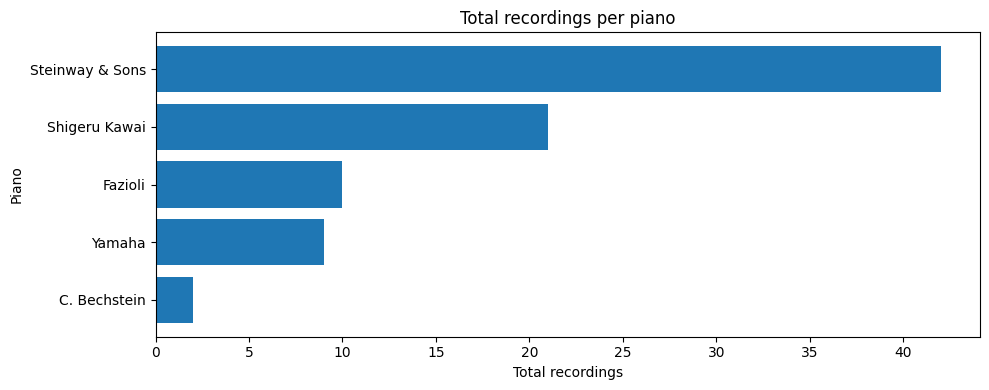

Zapisano: chart_total_per_piano.png


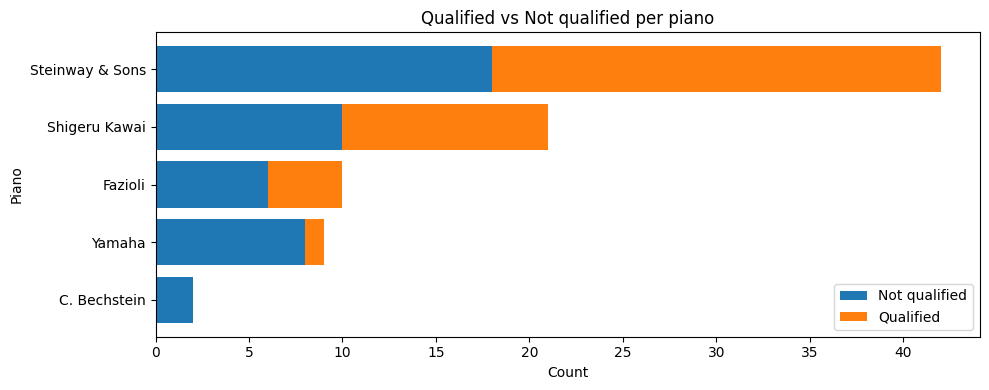

Zapisano: chart_stacked_qualified.png


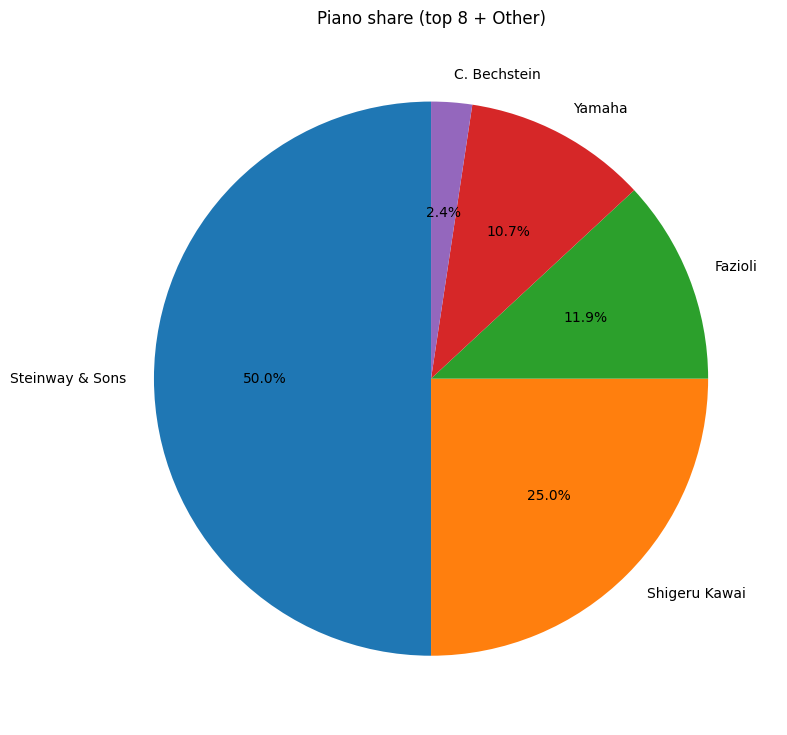

Zapisano: chart_pie_share.png


In [52]:
import os
import json
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# 1) ZLICZANIE
pianos = defaultdict(lambda: {"total": 0, "qualified": 0})
unknown_files = []  # <--- nowa lista do zbierania ścieżek z "Unknown"

root = "../Data/raw"  # zmień jeśli masz inną ścieżkę
for dirpath, _, filenames in os.walk(root):
    for filename in filenames:
        if filename.endswith(".json"):
            filepath = os.path.join(dirpath, filename)
            try:
                with open(filepath, encoding="utf-8") as f:
                    data = json.load(f)
                piano_name = (data.get("piano") or "").strip() or "Unknown"

                if piano_name == "Unknown":
                    unknown_files.append(filepath)  # <--- zapisz ścieżkę pliku

                pianos[piano_name]["total"] += 1
                if data.get("qualified"):
                    pianos[piano_name]["qualified"] += 1

            except Exception as e:
                print(f"[warn] Nie udało się odczytać {filepath}: {e}")

# 2) Jeśli są pliki z 'Unknown' – pokaż ich listę
if unknown_files:
    print("\n⚠️  Pliki z nieznanym fortepianem ('piano' == None lub brak linii):")
    for path in unknown_files:
        print("  -", path)
    print(f"🔎 Razem: {len(unknown_files)} plików z 'Unknown'\n")

# 3) DATAFRAME
rows = []
for piano, stats in pianos.items():
    total = stats["total"]
    qual = stats["qualified"]
    rows.append({
        "piano": piano,
        "total": total,
        "qualified": qual,
        "not_qualified": total - qual,
        "procentage of succes": str(round((qual / total) * 100, 2))+"%",
    })

df = pd.DataFrame(rows).sort_values("total", ascending=False).reset_index(drop=True)
print(df)

# zapis do CSV (opcjonalnie)
df.to_csv("pianos_summary.csv", index=False)
print("Zapisano: pianos_summary.csv")

# 4) WYKRES 1 — słupkowy (total per piano)
plt.figure(figsize=(10, max(4, 0.35*len(df))))
plt.barh(df["piano"], df["total"])
plt.xlabel("Total recordings")
plt.ylabel("Piano")
plt.title("Total recordings per piano")
plt.gca().invert_yaxis()  # największe na górze
plt.tight_layout()
plt.savefig("chart_total_per_piano.png", dpi=150)
plt.show()
print("Zapisano: chart_total_per_piano.png")

# 5) WYKRES 2 — słupkowy skumulowany (qualified vs not)
plt.figure(figsize=(10, max(4, 0.35*len(df))))
plt.barh(df["piano"], df["not_qualified"], label="Not qualified")
plt.barh(df["piano"], df["qualified"], left=df["not_qualified"], label="Qualified")
plt.xlabel("Count")
plt.ylabel("Piano")
plt.title("Qualified vs Not qualified per piano")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("chart_stacked_qualified.png", dpi=150)
plt.show()
print("Zapisano: chart_stacked_qualified.png")

# 6) WYKRES 3 — kołowy (udział top-N)
TOP_N = 8
df_pie = df.copy()
if len(df_pie) > TOP_N:
    top = df_pie.iloc[:TOP_N].copy()
    other_total = df_pie.iloc[TOP_N:]["total"].sum()
    top = pd.concat([top, pd.DataFrame([{"piano": "Other", "total": other_total}])], ignore_index=True)
else:
    top = df_pie[["piano", "total"]].copy()

plt.figure(figsize=(8, 8))
plt.pie(top["total"], labels=top["piano"], autopct="%1.1f%%", startangle=90)
plt.title(f"Piano share (top {TOP_N} + Other)")
plt.tight_layout()
plt.savefig("chart_pie_share.png", dpi=150)
plt.show()
print("Zapisano: chart_pie_share.png")


Pianos statistics